In [181]:
using Plots
xs =  1:1:10
ys = [rand() for x in xs]
xsf = xs[1]:0.01:last(xs)

1.0:0.01:10.0

### Zadanie 1

In [182]:
function LagrangeInterpolation(xs, ys)
    denominators = [reduce(*, [(xk - xi) for xi in xs if xi != xk]) for xk in xs]
    P(x) = sum([ys[k] * reduce(*, [x - xi for xi in xs if xi != xs[k]]) / denominators[k] for k in 1:length(xs)])
end

LagrangeInterpolation (generic function with 1 method)

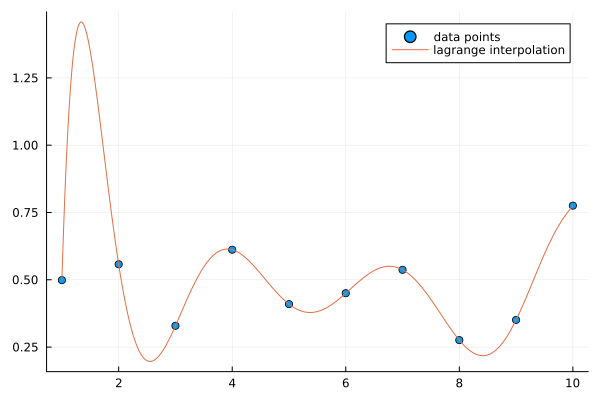

In [183]:
scatter(xs, ys, label="data points")

lagrange_inter = LagrangeInterpolation(xs, ys)
ysf = [lagrange_inter(x) for x in xsf]
plot!(xsf,ysf, label="lagrange interpolation")

### Zadanie 2

In [184]:
struct Newt
    table::Matrix{Float64}
    xs::Vector{Float64}
end

In [185]:
function NewtonInterpolation(xs, ys)
    n = length(xs)
    table = zeros(n, n)
    table[:, 1] = ys
    for tx in 2:n
        for ty in tx:n
            table[ty, tx] = (table[ty, tx-1] - table[ty-1, tx-1]) / (xs[ty] - xs[ty-tx+1])
        end
    end
    return Newt(table, xs)
end           

NewtonInterpolation (generic function with 1 method)

In [186]:
function Horner(newt, x)
    n = size(newt.table, 1)
    function W(i) 
        if i == n
            return newt.table[i, i]
        end
        return W(i + 1) * (x - newt.xs[i]) + newt.table[i, i]
    end
    W(1)
end

Horner (generic function with 1 method)

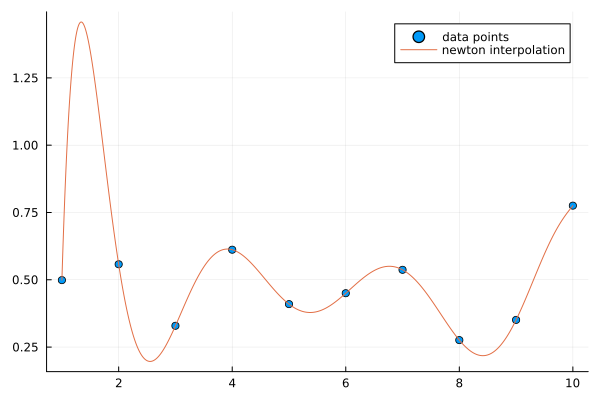

In [187]:
scatter(xs, ys, label="data points")

newton_inter = NewtonInterpolation(xs, ys)
ysf = [Horner(newton_inter, x) for x in xsf]
plot!(xsf,ysf, label="newton interpolation")

### Zadanie 3

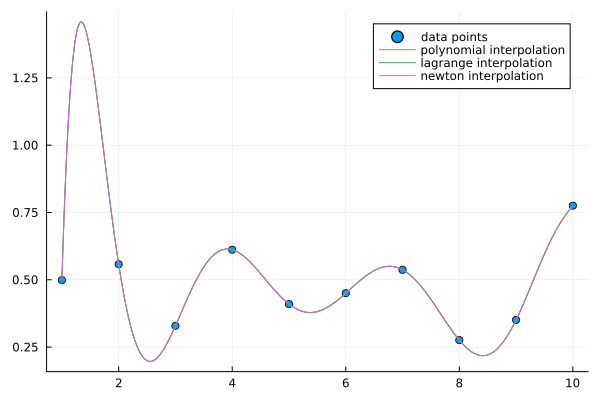

In [188]:
using Polynomials
scatter(xs, ys, label="data points")

f=fit(xs, ys)
ysf = [f(x) for x in xsf]
plot!(xsf, ysf, label="polynomial interpolation")

lagrange_inter = LagrangeInterpolation(xs, ys)
ysf = [lagrange_inter(x) for x in xsf]
plot!(xsf, ysf, label="lagrange interpolation")

newton_inter = NewtonInterpolation(xs, ys)
ysf = [Horner(newton_inter, x) for x in xsf]
plot!(xsf, ysf, label="newton interpolation")

### Zadanie 4

In [189]:
using DataFrames
using Statistics

df = DataFrame(nodes=Int64[], interpolation_type=String[], operation=String[], time=Float64[])

for nodes in 5:30
    xs = 1:1:nodes
    ys = [rand() for x in xs]
    xsf = xs[1]:0.01:last(xs)
    
    for _ in 1:10
        time = @elapsed lagrange_inter = LagrangeInterpolation(xs, ys)
        push!(df, [nodes, "lagrange", "creation", time])
        push!(df, [nodes, "lagrange", "points calculation", @elapsed [lagrange_inter(x) for x in xsf]])
    end
    for _ in 1:10
        time = @elapsed newton_inter = NewtonInterpolation(xs, ys)
        push!(df, [nodes, "newton", "creation", time])
        push!(df, [nodes, "newton", "points calculation", @elapsed [Horner(newton_inter, x) for x in xsf]])
    end
    for _ in 1:10
        time = @elapsed polynomial_inter = fit(xs, ys)
        push!(df, [nodes, "polynomial", "creation", time])
        push!(df, [nodes, "polynomial", "points calculation", @elapsed [polynomial_inter(x) for x in xsf]])
    end
end

In [190]:
df = groupby(df, [:nodes, :interpolation_type, :operation])
df = combine(df, :time => mean, :time => std)

Row,nodes,interpolation_type,operation,time_mean,time_std
,Int64,String,String,Float64,Float64
1,5,lagrange,creation,3.1489e-6,2.39782e-6
2,5,lagrange,points calculation,0.00482749,0.0142247
3,5,newton,creation,2.7588e-6,2.81564e-6
4,5,newton,points calculation,0.00483025,0.0147862
5,5,polynomial,creation,2.8211e-6,3.31161e-6
6,5,polynomial,points calculation,0.00387009,0.0122263
7,6,lagrange,creation,2.6042e-6,9.10299e-7
8,6,lagrange,points calculation,0.000548831,6.57652e-5
9,6,newton,creation,4.5107e-6,5.39248e-6


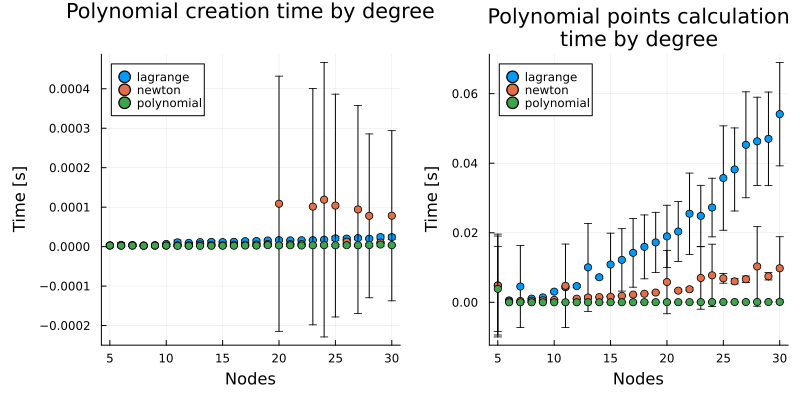

In [191]:
# using Pkg
# Pkg.add("StatsPlots")
using StatsPlots
using Plots.PlotMeasures
creation_plot = @df filter(:operation => n -> n == "creation", df) scatter(:nodes, :time_mean, group = :interpolation_type, yerr = :time_std, title = "Polynomial creation time by degree", ylabel="Time [s]", xlabel="Nodes")
calculation_plot = @df filter(:operation => n -> n == "points calculation", df) scatter(:nodes, :time_mean, group = :interpolation_type, yerr = :time_std, title = "Polynomial points calculation\ntime by degree", ylabel="Time [s]", xlabel="Nodes")
plot(creation_plot, calculation_plot, size=(800, 400), bottom_margin=5mm, left_margin=5mm, top_margin=5mm)

### Zadanie 5

In [198]:
xs =  1:1:10
ys = [rand() for x in xs]
xsf = xs[1]:0.01:last(xs)

1.0:0.01:10.0

In [199]:
function Neville(xs, ys, x)
    n = length(xs)
    table = zeros(n, n)
    table[:, 1] = ys
    for tx in 2:n
        for ty in tx:n
            table[ty, tx] = ((x - xs[ty]) * table[ty-1, tx-1] - (x - xs[ty-tx+1]) * table[ty, tx-1]) / (xs[ty-tx+1] - xs[ty])
#                              (table[ty, tx-1] - table[ty-1, tx-1]) / (xs[ty] - xs[ty-tx+1])
        end
    end
    table[n, n]
end

Neville (generic function with 1 method)

0.963345422290528


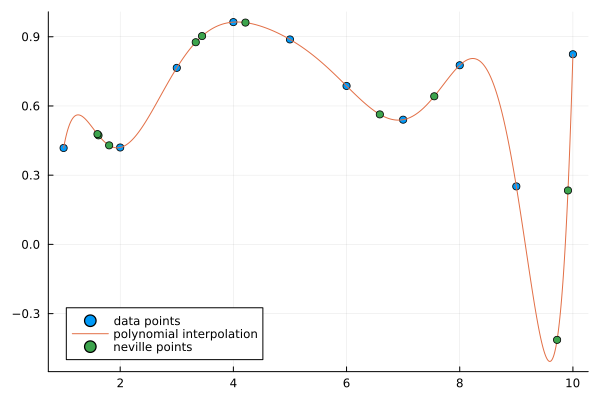

In [200]:
println(Neville(xs, ys, 4))

scatter(xs, ys, label="data points")

f=fit(xs, ys)
ysf = [f(x) for x in xsf]
plot!(xsf, ysf, label="polynomial interpolation")

neville_xs = [rand() * 10 for _ in 1:10]
ysf = [Neville(xs, ys, x) for x in neville_xs]
scatter!(neville_xs, ysf, label="neville points")

### Zadanie 6

In [201]:
xs =  1:1:19
ys = [rand() for x in xs]
xsf = xs[1]:0.01:last(xs)

1.0:0.01:19.0

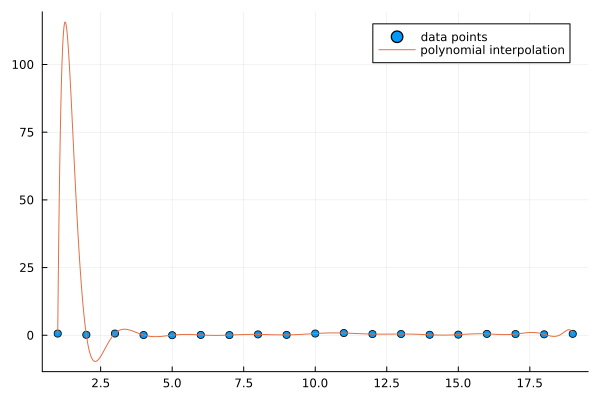

In [202]:
f=fit(xs, ys)
ysf = [f(x) for x in xsf]
scatter(xs, ys, label="data points")
plot!(xsf, ysf, label="polynomial interpolation")

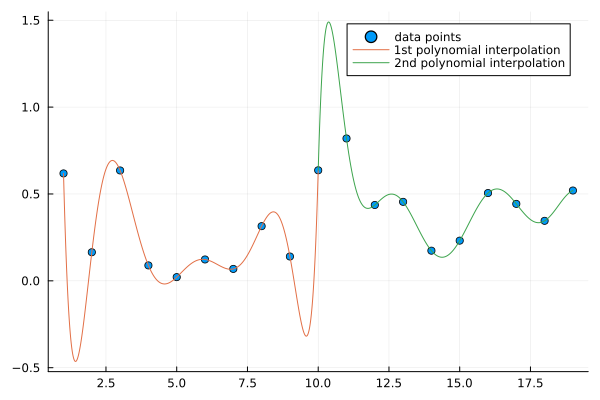

In [203]:
f1 = fit(xs[1:10], ys[1:10])
f2 = fit(xs[10:19], ys[10:19])
scatter(xs, ys, label="data points")
xsf1 = 1:0.01:10
xsf2 = 10:0.01:19
ysf1 = [f1(x) for x in xsf1]
ysf2 = [f2(x) for x in xsf2]
plot!(xsf1, ysf1, label="1st polynomial interpolation")
plot!(xsf2, ysf2, label="2nd polynomial interpolation")